In [42]:
!pip install -U langgraph langchain_openai tavily-python langchain_community

In [43]:
# import libraries
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import ToolMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool, Tool

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt

In [44]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [66]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [67]:
tavily = TavilySearchResults(max_results=2)
tools = [tavily]
llm = ChatOpenAI(model_name="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)

In [96]:
def chatbot(state: State):
  message = llm_with_tools.invoke(state["messages"])
  print(len(message.tool_calls))
  # assert len(message.tool_calls) <= 1
  return {"messages": [message]}

def reporter(state: State):
  message = llm_with_tools.invoke(state["messages"] + ["""
    You are a finantial trading report writer.
    Your job is to summarize the stock information gathered from previous messages and write a brief report on
    different influencers on the stock and the stock's recent behaviors.
  """])
  return {"messages": [message]}

In [97]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node(reporter)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition,)
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.add_edge("chatbot", "reporter")
graph_builder.add_edge("tools", "reporter")
graph_builder.add_edge("reporter", END)



In [98]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

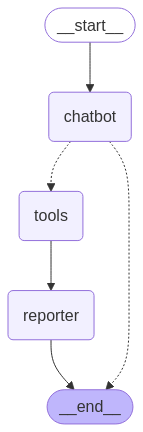

In [99]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [100]:
config = {"configurable": {"thread_id": "1"}}
user_input = (
    "Can you help me search online for NVDIA stocks' recent trend and give me a report?"
    "When you have the answer, output the result."
)

In [101]:
events = graph.stream(
  {"messages": [{"role": "user", "content": user_input}]},
  config,
  stream_mode="values",
)

for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you help me search online for NVDIA stocks' recent trend and give me a report?When you have the answer, output the result.
1
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ygxYm0oOOjDZNTlPJS8u40Ne)
 Call ID: call_ygxYm0oOOjDZNTlPJS8u40Ne
  Args:
    query: NVIDIA stock recent trend analysis
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "NVIDIA Corporation (NVDA) - Yahoo Finance", "url": "https://finance.yahoo.com/quote/NVDA/", "content": "NVIDIA Corporation (NVDA) Stock Price, News, Quote & History - Yahoo Finance NVIDIA Corporation (NVDA) NVIDIA Corporation Overview Semiconductors / Technology The Graphics segment offers GeForce GPUs for gaming and PCs, the GeForce NOW game streaming service and related infrastructure, and solutions for gamin